In [2]:
using IJulia
using Manopt, Manifolds, Random, LinearAlgebra, ManifoldDiff
using ManifoldDiff: grad_distance, prox_distance
using DifferentialEquations
using Plots, DataFrames
using DelimitedFiles

[ Info: Precompiling DifferentialEquations [0c46a032-eb83-5123-abaf-570d42b7fbaa] 
┌ Warning: The call to compilecache failed to create a usable precompiled cache file for DifferentialEquations [0c46a032-eb83-5123-abaf-570d42b7fbaa]
│   exception = Required dependency Base.PkgId(Base.UUID("7ed4a6bd-45f5-4d41-b270-4a48e9bafcae"), "LinearSolve") failed to load from a cache file.
└ @ Base loading.jl:2406
[ Info: Precompiling SteadyStateDiffEq [9672c7b4-1e72-59bd-8a11-6ac3964bc41f] 
┌ Warning: The call to compilecache failed to create a usable precompiled cache file for SteadyStateDiffEq [9672c7b4-1e72-59bd-8a11-6ac3964bc41f]
│   exception = Required dependency Base.PkgId(Base.UUID("7ed4a6bd-45f5-4d41-b270-4a48e9bafcae"), "LinearSolve") failed to load from a cache file.
└ @ Base loading.jl:2406
[ Info: Precompiling DiffEqCallbacks [459566f4-90b8-5000-8ac3-15dfb0a30def] 
┌ Warning: The call to compilecache failed to create a usable precompiled cache file for DiffEqCallbacks [459566f4-90b8-5

### Misc functions

In [3]:


function read_matrix(filename::String)
    """
    Reads a distance matrix from a file into a Julia array.
    
    Args:
        filename (String): The path to the file containing the distance matrix.
        
    Returns:
        Array{Int64, 2}: The distance matrix as a Julia array.
    """
    return readdlm(filename, ' ', Int)
end

function cycle_graph_adjacency_matrix(n::Int, directed::Bool=true)
    """
    Generates the adjacency matrix of a cycle graph of length n.

    Args:
        n (Int): The number of nodes in the cycle graph.
        directed (Bool): If true, generates a directed cycle graph.
                         If false, generates an undirected cycle graph.

    Returns:
        Array{Int64, 2}: The adjacency matrix of the cycle graph.
    """
    # Initialize an n x n matrix with zeros
    adj_matrix = zeros(Int, n, n)
    
    if directed
        # Directed cycle graph
        for i in 1:(n-1)
            adj_matrix[i, i+1] = 1
        end
        adj_matrix[n, 1] = 1  # Last node connects to the first node
    else
        # Undirected cycle graph
        for i in 1:(n-1)
            adj_matrix[i, i+1] = 1
            adj_matrix[i+1, i] = 1
        end
        adj_matrix[n, 1] = 1
        adj_matrix[1, n] = 1  # Last node connects to the first node and vice versa
    end
    
    return adj_matrix
end

function load_cnf(file_name)
    c = Nothing
    open(file_name) do file
        for (idx, line) in enumerate(eachline(file))
            if idx == 1
                N = parse(Int32, split(line, " ")[3])
                M = parse(Int32, split(line, " ")[4])
                c = zeros(M,N)
            else
                variables = split(line, " ")
                for var_str in variables
                    var = parse(Int32, var_str)
                    if var != 0
                        if var > 0
                            c[idx-1, var] = 1
                        elseif var < 0
                            c[idx-1, -var] = -1
                        end
                    end
                end
            end
        end
    end
    return c
end

function satisfied(spin_config, c)
    function check_clause(row, state)
        for (index,elem) in enumerate(row)
            if elem == state[index]
                return true
            end
        end
    end

    incorrect_flag = false
    for clause in eachrow(c)
        if check_clause(clause, spin_config) != true
            incorrect_flag = true
            break
        end
    end

    if incorrect_flag
        return false
    end
    return true
end

condition(u, t, integrator) = satisfied([s>0 ? 1 : -1 for s in u], c)
affect!(integrator) = terminate!(integrator)
cb = DiscreteCallback(condition, affect!)

DiscreteCallback{typeof(condition), typeof(affect!), typeof(SciMLBase.INITIALIZE_DEFAULT), typeof(SciMLBase.FINALIZE_DEFAULT)}(condition, affect!, SciMLBase.INITIALIZE_DEFAULT, SciMLBase.FINALIZE_DEFAULT, Bool[1, 1])

### Init. conditions & lodaing files

In [4]:
# Example usage
N = 5
directed = true  # Set to false for undirected
T = cycle_graph_adjacency_matrix(N, directed)
# println("Adjacency matrix for cycle graph of length $n (directed=$directed):")
# T
# 
# # Example usage
D = read_matrix("TSPs/test_N5.tsp")
# println("Read matrix from file:")
# D


5×5 Matrix{Int64}:
  0  83  21  34  26
 83   0  57  12  58
 21  57   0  30  34
 34  12  30   0  45
 26  58  34  45   0

# Manopt tests

In [5]:
n = 100
σ = π / 8
M = Sphere(2)
p = 1 / sqrt(2) * [1.0, 0.0, 1.0]
data = [exp(M, p,  σ * rand(M; vector_at=p)) for i in 1:n];

In [6]:
f(M, p) = sum(1 / (2 * n) * distance.(Ref(M), Ref(p), data) .^ 2)
grad_f(M, p) = sum(1 / n * grad_distance.(Ref(M), data, Ref(p)));

In [7]:
p = [1.0, 0.0, 0.0]

3-element Vector{Float64}:
 1.0
 0.0
 0.0

In [8]:
grad_f(M, p)

3-element Vector{Float64}:
 -0.0
  0.023241324712815637
 -0.6957306477428857

The gradient added to the point does not stay in the manifold

In [9]:
norm(p + grad_f(M, p))

1.2184339511779627

The retracted point does 

In [10]:
q = retract(M, p, grad_f(M, p))

3-element Vector{Float64}:
  0.7673367996250868
  0.021409230851779475
 -0.6408867924801264

In [11]:
norm(q)

1.0

Riemannian gradient descent (cannot be modified by additional dynamic terms)

In [12]:
m1 = gradient_descent(M, f, grad_f, data[1])

3-element Vector{Float64}:
  0.7424900431906298
 -0.032199646067121564
  0.6690827441773767

In [13]:
m2 = gradient_descent(M, f, grad_f, data[1];
    debug=[:Iteration,(:Change, "|Δp|: %1.9f |"),
        (:Cost, " F(x): %1.11f | "), "\n", :Stop],
    stopping_criterion = StopAfterIteration(6)
  )

Initial  F(x): 0.36785934832 | 
# 1     |Δp|: 1.228772864 | F(x): 0.27577180392 | 
# 2     |Δp|: 0.954413660 | F(x): 0.22158942140 | 
# 3     |Δp|: 0.743889574 | F(x): 0.18848567520 | 
# 4     |Δp|: 0.580026615 | F(x): 0.16859913589 | 
# 5     |Δp|: 0.452904028 | F(x): 0.15641786839 | 
# 6     |Δp|: 0.353623266 | F(x): 0.14903875315 | 
The algorithm reached its maximal number of iterations (6).


3-element Vector{Float64}:
 0.6521924118691368
 0.05923767866493146
 0.7557353738754782

# Orthogonal matrices

In [14]:
N = 5
M₀ = OrthogonalMatrices(N)
M₁ = UnitaryMatrices(N, ℝ)

OrthogonalMatrices(5)

## Cost function
$$
V_\text{TSP} (P)= \text{tr} \left(D^T P^T T P \right)
$$
where $P$ are $N$ by $N$ real matrices, with the constraint that $P$ is a representation of a permutation from the symmetric group $\mathcal{S}_N$

In [15]:
cost_fnc(P) = tr(transpose(D)*transpose(P)*T*P)

cost_fnc (generic function with 1 method)

In [16]:
cost_fnc(rand(M₀))

-29.077656934097334

## Dynamics over manifold

The Riemannian gradient over the manifold $\mathcal{M} \equiv \mathcal{O}_N$ is:
$$\nabla_{\mathcal{M}} V_\text{TSP} (P) = P \left[ \left\{ P^T T P, D  \right\} + \left\{ P^T T^T P, D^T  \right\} \right]$$

In [17]:
# Custom infix operator for the Lie bracket
⊖(A, B) = transpose(A) * B - transpose(B) * A

# Right hand side of the dif
function basic_rule!(du, u, params, t)
    D = params[1]
    T = params[2]
    N = size(D, 1)  # Dimension of the matrix

    # Reshape the vector u to get the matrix P
    P = reshape(u, N, N)

    # Compute the Lie brackets
    bracket1 = ⊖(transpose(P) * T * P, D)
    bracket2 = ⊖(transpose(P) * transpose(T) * P, transpose(D))
 
    # Compute the update rule
    dP_dt = P * (bracket1 + bracket2)

    # dP_dt = retract(M₀, P0, dP_dt) # To ensure we stay on the manifold

    # Convert the matrix dP_dt to a vector
    du[:] = - vec(dP_dt)  # Flatten the matrix into a vector
end

basic_rule! (generic function with 1 method)

In [18]:
# define problem and run simulation
params = (D, T)     # (p, a, b, N, J)
tspan = (0.0,1.5)

# initial condition(s)
P0 = rand(M₀) # This is P(t=0)
u0 = vec(P0) # somehow encode the matrix rand(M₀) into a vector  


#p, beta, alpha, N J
prob = ODEProblem(basic_rule!, u0, tspan, params)
sol = solve(prob, Tsit5());

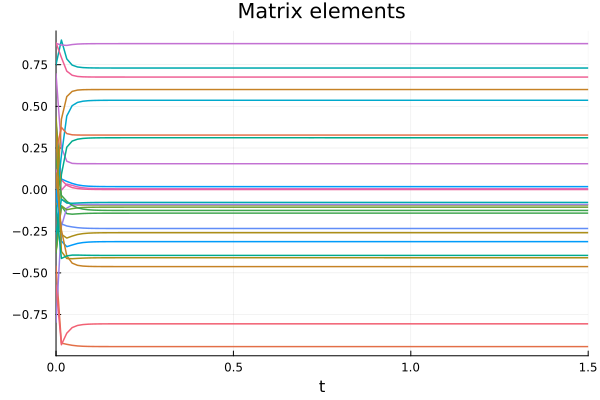

In [19]:
plot(sol, idxs=1:N*N, plotdensity=100, lw=1.5, title="Matrix elements", legend=false)

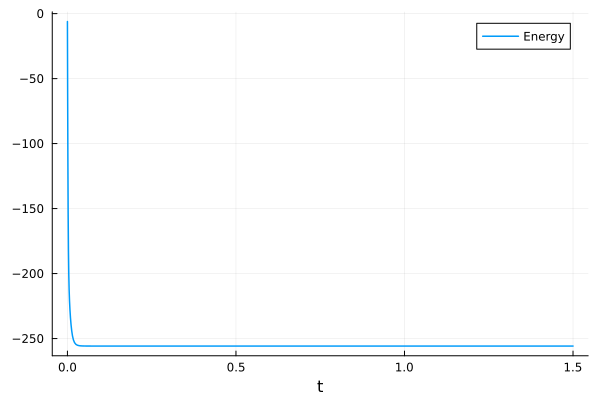

In [20]:
plot(sol.t,[ cost_fnc(reshape(x_t, N, N)) for x_t in sol.u] , label="Energy", lw=1.5, xlabel="t")

# Permutation matrix constraint

### Logical Formulation for Permutation Matrix

To define a permutation matrix $ P $ using a logical function $ F(P_{11}, P_{12}, \dots, P_{NN}) $, we ensure that:

1. **Each row contains exactly one '1'.**
2. **Each column contains exactly one '1'.**

#### 1. **Row Condition:**

For each row $ i $, there must be exactly one '1' in that row. This can be expressed as:

$$
\bigwedge_{i=1}^{N} \left( \bigvee_{j=1}^{N} \left( P_{ij} \land \bigwedge_{k \neq j} \neg P_{ik} \right) \right)
$$

This expression ensures that for each row $ i $, there exists exactly one $ j $ such that $ P_{ij} = 1 $, and for all other columns $ k \neq j $, $ P_{ik} = 0 $.

#### 2. **Column Condition:**

Similarly, for each column $ j $, there must be exactly one '1' in that column. This can be expressed as:

$$
\bigwedge_{j=1}^{N} \left( \bigvee_{i=1}^{N} \left( P_{ij} \land \bigwedge_{k \neq i} \neg P_{kj} \right) \right)
$$

This expression ensures that for each column $ j $, there exists exactly one $ i $ such that $ P_{ij} = 1 $, and for all other rows $ k \neq i $, $ P_{kj} = 0 $.

### Final Logical Function $ F $:

The overall logical function $ F $ that defines a permutation matrix $ P $ is the conjunction of both the row and column conditions:

$$
F(P_{11}, P_{12}, \dots, P_{NN}) = \left( \bigwedge_{i=1}^{N} \bigvee_{j=1}^{N} \left( P_{ij} \land \bigwedge_{k \neq j} \neg P_{ik} \right) \right) \land \left( \bigwedge_{j=1}^{N} \bigvee_{i=1}^{N} \left( P_{ij} \land \bigwedge_{k \neq i} \neg P_{kj} \right) \right)
$$

This function $ F $ is satisfied if and only if $ P $ is a permutation matrix, ensuring that each row and each column contains exactly one '1'.


## Converting a Logical Function to CNF Format

### Overview

To convert a logical function $ F $ that characterizes a permutation matrix into Conjunctive Normal Form (CNF), follow these steps:

### 1. Define the Logical Function

The logical function $ F $ ensures that a matrix $ P $ is a permutation matrix. It can be expressed as:

$$
F(P_{11}, P_{12}, \dots, P_{NN}) = \left( \bigwedge_{i=1}^{N} \bigvee_{j=1}^{N} \left( P_{ij} \land \bigwedge_{k \neq j} \neg P_{ik} \right) \right) \land \left( \bigwedge_{j=1}^{N} \bigvee_{i=1}^{N} \left( P_{ij} \land \bigwedge_{k \neq i} \neg P_{kj} \right) \right)
$$

### 2. Ensure At Least One '1' in Each Row

For each row $ i $, create a clause that ensures at least one entry in that row is '1':

$$
\bigvee_{j=1}^{N} P_{ij}
$$

#### Example for $ N = 3 $:

$$
P_{i1} \lor P_{i2} \lor P_{i3}
$$

### 3. Ensure No Two '1's in the Same Row

For each row $ i $, ensure that no two columns $ j $ and $ k $ (where $ j \neq k $) both contain '1's:

$$
\bigwedge_{j \neq k} (\neg P_{ij} \lor \neg P_{ik})
$$

#### Example for $ N = 3 $:

$$
(\neg P_{i1} \lor \neg P_{i2}) \land (\neg P_{i1} \lor \neg P_{i3}) \land (\neg P_{i2} \lor \neg P_{i3})
$$

### 4. Combine the Clauses

The CNF expression for each row combines the clauses ensuring at least one '1' and no two '1's in the same row:

$$
\left( \bigvee_{j=1}^{N} P_{ij} \right) \land \left( \bigwedge_{j \neq k} (\neg P_{ij} \lor \neg P_{ik}) \right)
$$

#### Example for $ N = 3 $:

$$
(P_{i1} \lor P_{i2} \lor P_{i3}) \land (\neg P_{i1} \lor \neg P_{i2}) \land (\neg P_{i1} \lor \neg P_{i3}) \land (\neg P_{i2} \lor \neg P_{i3})
$$

### 5. Ensure No Two '1's in Each Column

Repeat the above steps for each column to ensure that no two entries in the same column are both '1'. This results in similar clauses for columns.

The CNF clauses for columns would be:

$$
\left( \bigvee_{i=1}^{N} P_{ij} \right) \land \left( \bigwedge_{i \neq k} (\neg P_{ij} \lor \neg P_{kj}) \right)
$$



## CTDS for enforcing permutation constraint



$$
\frac{d P_{ij}}{dt} = \sum_{m=1}^M a_m K_m^2(P)
$$
$$
\frac{d a_m}{dt} = a_m K_m(P)
$$
where
$$
K_m(P) = 2^{-k_m} \prod_\alpha^{N^2} (1-c_{m\alpha} P_{ij})
$$
and where $i = \left\lfloor \frac{\alpha}{N} \right\rfloor$
and $j = \alpha \mod N$

In [21]:
function CTDS_rule!(du, u, p, t)
    c = p[1]
    M, N = size(c)
    s = u[1:N]
    a = u[N+1:end]

    for i in 1:N 
        du[i] = sum([2*a[m]*c[m,i]*(0.125*prod([ j!=i ? (1-c[m, j]*s[j]) : 1 for j in 1:length(s)]))^2*(1-c[m, i]*s[i]) for m in 1:M])
    end
    for m in 1:M
        du[N+m] = a[m]*( 0.125*prod([ (1-c[m, j]*s[j]) for j in 1:N]) )^2
    end
    return nothing
end

CTDS_rule! (generic function with 1 method)

In [24]:
c = load_cnf("permut_test_N5.cnf")
M, N² = size(c)

k = Array{Int}(undef, M)
for row ∈ eachrow(c)
    k = count(x -> x != 0, row)
end

u0 = ones(N²+M);
u0[1:N²] = 2*rand(Float64, N²) -ones(N²);

In [25]:
p = (c, 0.001)
tspan = (0.0,100.0)

prob = ODEProblem(CTDS_rule!, u0, tspan, p);
sol1 = solve(prob, callback = cb);

┌ Warning: To maintain consistency with solution indexing, keyword argument vars will be removed in a future version. Please use keyword argument idxs instead.
│   caller = ip:0x0
└ @ Core :-1


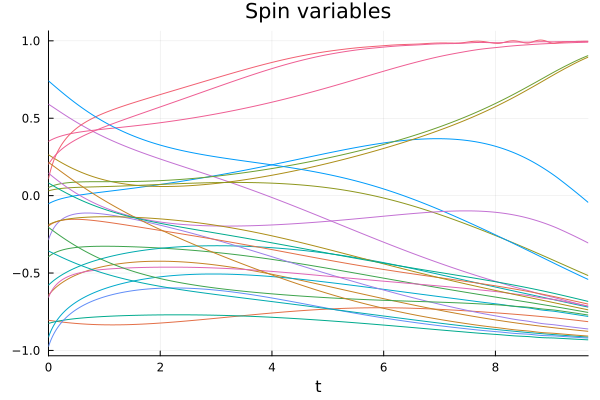

In [26]:
plot(sol1, xaxis="t", vars=(1:N²), legend=false)
title!("Spin variables")

In [27]:
function round_to_nearest_pm1(x)
    return x < 0.0 ? 0 : 1
end

function round_array_to_pm1(arr)
    return map(round_to_nearest_pm1, arr)
end


reshape(round_array_to_pm1(sol1.u[end][1:N²]), 5, 5)'

5×5 adjoint(::Matrix{Int64}) with eltype Int64:
 0  0  0  0  1
 0  1  0  0  0
 0  0  0  1  0
 1  0  0  0  0
 0  0  1  0  0

# Retracting the CDTS permutation constraint

The equation of motion for the dynamical system
$$
\frac{dP}{dt} = \mathcal{R}_{\mathcal{M}} \left( - \nabla V_\text{SAT}(P) \right)
$$



In [60]:
# Custom infix operator for the Lie bracket
⊖(A, B) = transpose(A) * B - transpose(B) * A
function RCTDS_rule!(du, u, p, t)
    c = p[1]
    k = p[2]
    β = p[3]
    M₀ = p[4]

    M, N² = size(c)

    s = u[1:N²]
    P = reshape(s, N, N)
    a = u[N²+1:end]

    # Compute the Lie brackets
    #bracket1 .= ⊖(transpose(P) * T * P, D)
    #bracket2 .= ⊖(transpose(P) * transpose(T) * P, transpose(D))

    # Calculating the constraint vector field
    for i in 1:length(s)
        du[i] = sum([2*a[m]*c[m,i]*(k[m]*prod([ j!=i ? (1-c[m, j]*s[j]) : 1 for j in 1:length(s)]))^2*(1-c[m, i]*s[i]) for m in 1:M])
    end
    for m in 1:M
        du[N²+m] = a[m]*k[m]*prod([ (1-c[m, j]*s[j]) for j in 1:length(s)])
    end
    # Scaling the CTDS backend
    # du[1:N²] .*= 1/β

    # Note that this may point out of the manifold

    tangent_P = reshape(du[1:N²], N, N)
    dP_dt = retract(M₀, P, tangent_P) - P # Point where the dynamics should go


    # Adding the Riemannian gradient, by converting the matrix dP_dt to a vector
    du[1:N²] = vec(dP_dt)  # Flatten the matrix into a vector

    return nothing
end

RCTDS_rule! (generic function with 1 method)

In [61]:
du = Array{Float64}(undef, N²+M)
p = (c, k, 10.0, M₀)
RCTDS_rule!(du, u0, p, 0.0)

LoadError: BoundsError: attempt to access Int64 at index [2]

In [59]:
asf = p[2]

2

In [45]:
p = (c, k, 10.0, M₀)
tspan = (0.0,10.0)

# initial condition(s)
P0 .= rand(M₀) # This is P(t=0)
u0 .= vcat(vec(P0), ones(M)) # vectorize permutation matrix and concatenate initial condition for auxiliary variables  


prob2 = ODEProblem(RCTDS_rule!, u0, tspan, p);
sol2 = solve(prob2, callback = cb);

LoadError: BoundsError: attempt to access Tuple{Matrix{Int64}, Matrix{Int64}} at index [3]

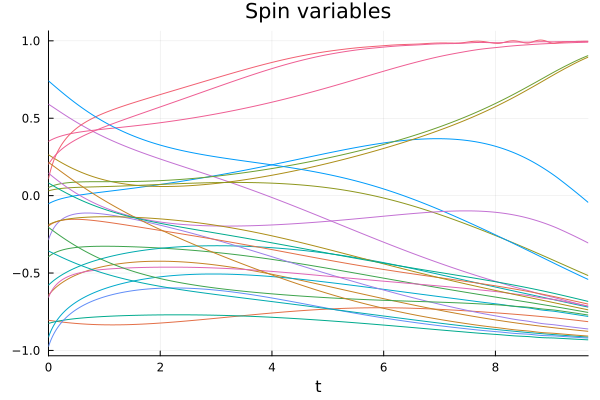

In [44]:
plot(sol2, xaxis="t", vars=(1:N²), legend=false)
title!("Spin variables")

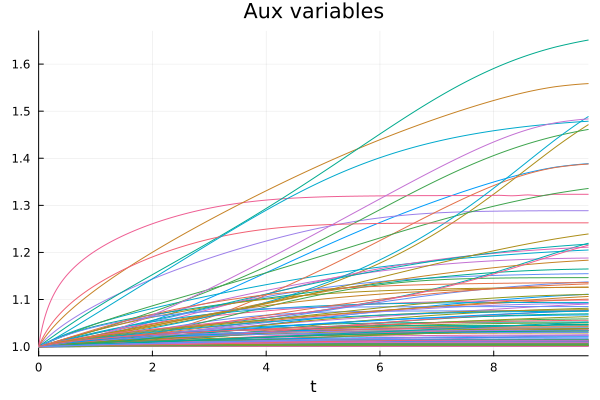

In [31]:
plot(sol2, xaxis="t", vars=(N²+1:N²+M), legend=false)
title!("Aux variables")

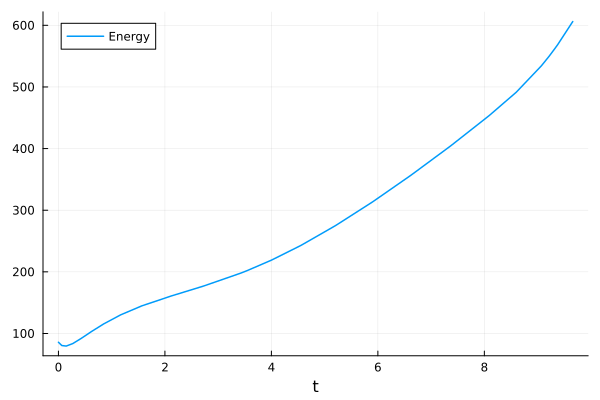

In [32]:
plot(sol2.t,[ cost_fnc(reshape(x_t[1:N²], N, N)) for x_t in sol2.u] , label="Energy", lw=1.5, xlabel="t")

# Combined dynamics

The equation of motion
$$
\frac{dP}{dt} = \mathcal{R}_{\mathcal{M}} \left( - \nabla V_\text{SAT}(P) \right) -\nabla_{\mathcal{M}} V_\text{TSP} (P)
$$